## Import Libraries 

In [109]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
from datetime import datetime

## Reading FDA data records of approved drugs

In [110]:
# Load the JSON file
with open("drug-ndc-0001-of-0001.json", "r") as f:
    data = json.load(f)

# Check the type of the top-level object
print("Top-level type:", type(data))

# If it's a list, print the first item
if isinstance(data, list):
    print("First item in list:")
    print(json.dumps(data[0], indent=2))

# If it's a dictionary, print the keys and first key-value pair
elif isinstance(data, dict):
    print("Top-level keys:", list(data.keys())[:5])
    first_key = next(iter(data))
    print("First item in dict:")
    print(json.dumps(data[first_key], indent=2))

Top-level type: <class 'dict'>
Top-level keys: ['meta', 'results']
First item in dict:
{
  "disclaimer": "Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service.",
  "terms": "https://open.fda.gov/terms/",
  "license": "https://open.fda.gov/license/",
  "last_updated": "2025-03-28",
  "results": {
    "skip": 0,
    "limit": 131124,
    "total": 131124
  }
}


In [111]:
# creating a list of dictionaries
drug_list = data['results'] 

# Print the number of entries and the first item
print(f"Number of drug entries: {len(drug_list)}")
print(json.dumps(drug_list[0], indent=2))


Number of drug entries: 131124
{
  "product_ndc": "0555-9028",
  "generic_name": "Norethindrone Acetate and Ethinyl Estradiol and Ferrous Fumarate",
  "labeler_name": "Teva Pharmaceuticals USA, Inc.",
  "brand_name": "Junel Fe 28 Day",
  "brand_name_suffix": "Fe 28 Day",
  "finished": true,
  "packaging": [
    {
      "package_ndc": "0555-9028-58",
      "description": "6 POUCH in 1 CARTON (0555-9028-58)  / 1 BLISTER PACK in 1 POUCH / 1 KIT in 1 BLISTER PACK",
      "marketing_start_date": "20030918",
      "sample": false
    }
  ],
  "listing_expiration_date": "20251231",
  "openfda": {
    "manufacturer_name": [
      "Teva Pharmaceuticals USA, Inc."
    ],
    "rxcui": [
      "259176",
      "1358762",
      "1358763",
      "1358765",
      "1358776",
      "1358780",
      "1359022",
      "1359023",
      "1359025",
      "1359028",
      "1359030"
    ],
    "spl_set_id": [
      "8b82ad14-580c-4145-b825-dce849f95363"
    ],
    "is_original_packager": [
      true
    ],
   

In [112]:
# Creating dataframe
drug_entries = data["results"]

# Build a list of dictionaries for each entry with required fields
records = []
for entry in drug_entries:
    record = {
        "generic_name": entry.get("generic_name"),
        "brand_name": entry.get("brand_name"),
        "marketing_start_date": entry.get("marketing_start_date")
    }
    
    # Extract pharm_class_epc and pharm_class_moa from nested openfda
    openfda = entry.get("openfda", {})
    record["pharm_class_epc"] = ", ".join(openfda.get("pharm_class_epc", []))
    record["pharm_class_moa"] = ", ".join(openfda.get("pharm_class_moa", []))
    record["manufacturer_name"] = ", ".join(openfda.get("manufacturer_name", []))
    records.append(record)

# Create DataFrame
df = pd.DataFrame(records)

# Preview the result
df.head(5)


,generic_name,brand_name,marketing_start_date,pharm_class_epc,pharm_class_moa,manufacturer_name
0,Norethindrone Acetate and Ethinyl Estradiol an...,Junel Fe 28 Day,20030918,Estrogen [EPC],Estrogen Receptor Agonists [MoA],"Teva Pharmaceuticals USA, Inc."
1,SEVELAMER CARBONATE,Sevelamer carbonate,20171026,,,Exelan Pharmaceuticals Inc.
2,Levonorgestrel and Ethinyl Estradiol,Aviane,20010402,,,"Teva Pharmaceuticals USA, Inc."
3,OSELTAMIVIR PHOSPHATE,OSELTAMIVIR PHOSPHATE,20231201,,,"Exelan Pharmaceuticals, Inc."
4,Tamsulosin hydrochloride,Tamsulosin hydrochloride,20240301,,,


In [113]:
df.shape

(131124, 6)

## Handling with missing values

In [114]:
df.isnull().sum()

generic_name                3
brand_name              20230
marketing_start_date        0
pharm_class_epc             0
pharm_class_moa             0
manufacturer_name           0
dtype: int64

In [115]:
df_dropped=df.drop_duplicates(subset = 'brand_name')
df_dropped.shape

(40281, 6)

In [116]:
df.sort_values(by=["generic_name"], inplace=True)
df.head()

,generic_name,brand_name,marketing_start_date,pharm_class_epc,pharm_class_moa,manufacturer_name
33325,(CHLOROPROCAINE HCI,(CHLOROPROCAINE HCI,20191013,,,"HF Acquisition Co LLC, DBA HealthFirst"
82181,(Ge-68) GERMANIUM CHLORIDE / (Ga-68) GALLIUM C...,None,20141106,,,
82182,(Ge-68) GERMANIUM CHLORIDE/(Ga-68) GALLIUM CHL...,None,20141106,,,
16239,(Ge-68) GERMANIUM CHLORIDE/(Ga-68) GALLIUM CHL...,None,20210901,,,
55790,(Ge-68) GERMANIUM CHLORIDE/(Ga-68) GALLIUM CHL...,None,20141106,,,


In [117]:
df = df.drop_duplicates(subset=["brand_name", "marketing_start_date"])
df.shape

(72677, 6)

In [118]:
df = df[~(df['brand_name'].isna())]

In [119]:
import warnings
warnings.filterwarnings('ignore')

df['generic_name'].fillna('Unknown', inplace=True)

In [120]:
df.isnull().sum()

generic_name            0
brand_name              0
marketing_start_date    0
pharm_class_epc         0
pharm_class_moa         0
manufacturer_name       0
dtype: int64

## Convert the column to datetime format

In [121]:
df['marketing_start_date'] = pd.to_datetime(df['marketing_start_date'], format="%Y%m%d", errors='coerce')

# Format the date as YYYY-MM
df['marketing_start_date'] = df['marketing_start_date'].dt.strftime('%Y-%m')


In [122]:
df.head()

,generic_name,brand_name,marketing_start_date,pharm_class_epc,pharm_class_moa,manufacturer_name
33325,(CHLOROPROCAINE HCI,(CHLOROPROCAINE HCI,2019-10,,,"HF Acquisition Co LLC, DBA HealthFirst"
85853,(SOTRADECOL) SODIUM TETRADECYL SULFATE,(SOTRADECOL) SODIUM TETRADECYL SULFATE,2021-06,,,"HF Acquisition Co LLC, DBA HealthFirst"
101761,"(To Deliver) Avobenzone 2%, Homosalate 8%, Oct...",Coppertone Sport Sunscreen SPF 30,2023-11,,,Beiersdorf Inc
101765,"(To Deliver) Avobenzone 2%, Octisalate 4.5%, O...",Coppertone Tanning Sunscreen SPF 15,2023-12,,,Beiersdorf Inc
49261,"(To Deliver) Avobenzone 3%, Homosalate 10%, Oc...",Coppertone Kids Sunscreen SPF 50,2024-01,,,Beiersdorf Inc


## Remove duplication

In [123]:
df.duplicated(subset=['generic_name', 'marketing_start_date']).sum()

16400

In [124]:
df = df.drop_duplicates(subset=['generic_name', 'marketing_start_date'])

In [125]:
df.shape

(50788, 6)

In [126]:
df = df.drop_duplicates(subset=['brand_name', 'marketing_start_date'])

In [127]:
df.shape

(50201, 6)

## Loading clinical trials data
1. df_intervention is based on AACT table that provides information on whether the drug is experimental or placebo ("group_type")
2. Main_df is the ClinicalTrials.gov dataset that is used here to provide information regarding study status, phase and completion year

In [128]:
df_interventions=pd.read_csv('AACT_with_int_groups_2205_1.csv', usecols=['nct_id',
       'name', 'group_type'])

In [129]:
df_interventions.columns

Index(['nct_id', 'name', 'group_type'], dtype='object')

In [130]:
df_interventions = df_interventions[(df_interventions['group_type'] == 'EXPERIMENTAL')]
df_interventions.shape

(358285, 3)

In [131]:
main_df=pd.read_csv('ctgAll_EDA1205_atcc.csv', usecols=['NCT_Number','Completion_Year','Phases_Simplified', 'Study_Status'])
main_df.shape

(223546, 4)

In [132]:
main_df.Study_Status.value_counts()

Study_Status
COMPLETED                  144118
UNKNOWN                     37553
RECRUITING                  14793
TERMINATED                  14046
ACTIVE_NOT_RECRUITING        6459
NOT_YET_RECRUITING           4751
ENROLLING_BY_INVITATION      1233
SUSPENDED                     528
WITHDRAWN                      65
Name: count, dtype: int64

In [133]:
main_df=main_df[
    (main_df.Study_Status == 'COMPLETED')]
main_df.shape


(144118, 4)

In [134]:
main_df.rename(columns={
    'NCT_Number':'nct_id'
    }, inplace=True)


In [135]:
main_df = main_df[
    (main_df['Phases_Simplified'] == 'PHASE3')]
main_df.shape


(13719, 4)

In [136]:
df_int= main_df.merge(
    df_interventions,
    on='nct_id',
    how='left',
    validate='one_to_many'  
)

print(df_int.shape)
print(df_int.columns)
print(df_int.nct_id.nunique())


(21797, 6)
Index(['nct_id', 'Study_Status', 'Completion_Year', 'Phases_Simplified',
       'name', 'group_type'],
      dtype='object')
13719


In [137]:
import unicodedata
import pandas as pd

# Helper to clean strings
def clean_text(s):
    if pd.isna(s):
        return ''
    return unicodedata.normalize('NFKD', str(s)).encode('ascii', 'ignore').decode('utf-8').strip().lower()

# Clean relevant columns
df['clean_generic'] = df['generic_name'].apply(clean_text)
df['clean_brand'] = df['brand_name'].apply(clean_text)
df_int['clean_name'] = df_int['name'].apply(clean_text)

# Match on clean_generic
matched_generic = df_int.merge(df, left_on='clean_name', right_on='clean_generic', how='inner')
# Match on clean_brand
matched_brand = df_int.merge(df, left_on='clean_name', right_on='clean_brand', how='inner')
# Combine matched results
matched = pd.concat([matched_generic, matched_brand], ignore_index=True)

# Build matched_df
matched_df = matched[['nct_id', 'name', 'marketing_start_date', 'manufacturer_name']].drop_duplicates()
matched_df['Is_FDA_approved'] = True

# Identify unmatched (by nct_id + name combo)
all_ncts = df_int[['nct_id', 'name']].drop_duplicates()
matched_keys = matched_df[['nct_id', 'name']]
unmatched_df = pd.merge(all_ncts, matched_keys, on=['nct_id', 'name'], how='outer', indicator=True)
unmatched_df = unmatched_df[unmatched_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# Add missing info to unmatched
unmatched_df['marketing_start_date'] = None
unmatched_df['manufacturer_name'] = None
unmatched_df['Is_FDA_approved'] = False

# Combine both
final_df = pd.concat([matched_df, unmatched_df], ignore_index=True)


In [138]:
final_df.Is_FDA_approved.value_counts()

Is_FDA_approved
True     65103
False    14012
Name: count, dtype: int64

In [139]:
final_df.name.nunique()

8017

In [140]:
final_df.rename(columns={
                     'name':'clean_name'},
inplace=True)



In [141]:
df_int.columns

Index(['nct_id', 'Study_Status', 'Completion_Year', 'Phases_Simplified',
       'name', 'group_type', 'clean_name'],
      dtype='object')

In [142]:
# Merge just on nct_id and clean drug name
merged = df_int.merge(
    final_df,
    on=['nct_id', 'clean_name'],
    how='left',
    suffixes=('_trial', '_approval')
)

# Extend approval window to 5 years
merged['reached_fda_milestone'] = (
    merged['start_marketing_year'].notnull() &
    (merged['start_marketing_year'] - merged['Completion_Year'] <= 2) &
    (merged['start_marketing_year'] - merged['Completion_Year'] >= 0)
)
# Safely select columns for final output
cols_to_include = ['nct_id', 'Completion_Year', 'Sponsor', 'clean_name', 
                   'marketing_start_date', 'manufacturer_name', 
                   'start_marketing_year', 'reached_fda_milestone']

result_df = merged[[col for col in cols_to_include if col in merged.columns]]



# Determine if the trial reached FDA milestone (approved within 2 years of completion)
merged['reached_fda_milestone'] = (
    merged['start_marketing_year'].notnull() &
    (merged['start_marketing_year'] - merged['Completion_Year'] <= 2) &
    (merged['start_marketing_year'] - merged['Completion_Year'] >= 0)
)

# Build final result DataFrame
result_df = merged[['nct_id', 'Completion_Year', 'Sponsor', 'clean_name', 
                    'marketing_start_date', 'manufacturer_name', 
                    'start_marketing_year', 'reached_fda_milestone']]

# Visualization
sns.countplot(data=result_df, x='reached_fda_milestone')
plt.title('Trials That Reached FDA Approval Milestone')
plt.xlabel('Reached FDA Milestone')
plt.ylabel('Number of Trials')
plt.show()


KeyError: 'start_marketing_year'

In [ ]:
result_df.reached_fda_milestone.value_counts()

In [ ]:
result_df.head(2)

In [ ]:
#groupby -(['nct_id', 'clean_name']
grouped_result = merged.groupby(['nct_id', 'clean_name'])['reached_fda_milestone'].any().reset_index()
merged = merged.drop(columns=['reached_fda_milestone'])  # avoid conflict
merged = merged.merge(grouped_result, on=['nct_id', 'clean_name'], how='left')
merged.shape

In [ ]:
merged.head(2)

In [ ]:
merged.nct_id.value_counts()	

In [ ]:
# Count rows per nct_id in both dataframes BEFORE merging
print(df_int['nct_id'].value_counts().head())
print(final_df['nct_id'].value_counts().head())


In [ ]:
merged_unique = merged.drop_duplicates(subset=['nct_id', 'clean_name'])
print("Original merged shape:", merged.shape)
print("Deduplicated shape:", merged_unique.shape)    

In [ ]:
merged_unique.groupby('nct_id')['clean_name'].nunique().sort_values(ascending=False).head(10)

In [ ]:
# Aggregate to decide trial-level success
trial_success = merged_unique.groupby('nct_id')['reached_fda_milestone'].any().reset_index()

# Rename for clarity
trial_success = trial_success.rename(columns={'reached_fda_milestone': 'trial_success'})

# Optional: merge back with trial metadata if needed
df_trial_level = df_int.merge(trial_success, on='nct_id', how='left')


In [ ]:
df_trial_level.head()

In [ ]:
df_trial_level.trial_success.value_counts()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing or non-numeric years
approved = merged_unique[merged_unique['reached_fda_milestone'] == True].copy()
approved['start_marketing_year'] = pd.to_numeric(approved['start_marketing_year'], errors='coerce')
approved = approved.dropna(subset=['start_marketing_year'])

# Convert to int for histogram bins
approved['start_marketing_year'] = approved['start_marketing_year'].astype(int)

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=approved, x='start_marketing_year', bins=range(approved['start_marketing_year'].min(), approved['start_marketing_year'].max() + 1), kde=False, color="#66c2a5")

plt.title('FDA Drug Approvals Per Year (from Trials)')
plt.xlabel('Start Marketing Year')
plt.ylabel('Number of Approvals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure correct date type
df['marketing_start_year'] = pd.to_datetime(df['marketing_start_date'], errors='coerce').dt.year

# Filter valid years
df_valid = df.dropna(subset=['marketing_start_year'])
df_valid['marketing_start_year'] = df_valid['marketing_start_year'].astype(int)

# Deduplicate
brand_approvals = df_valid.dropna(subset=['brand_name']).drop_duplicates(subset=['brand_name', 'marketing_start_year'])
generic_approvals = df_valid.dropna(subset=['generic_name']).drop_duplicates(subset=['generic_name', 'marketing_start_year'])

# Plotting
plt.figure(figsize=(12, 6))

sns.histplot(
    brand_approvals['marketing_start_year'],
    bins=range(df_valid['marketing_start_year'].min(), df_valid['marketing_start_year'].max() + 1),
    color='steelblue',
    label='Brand Name Approvals',
    kde=False,
    element='step'
)

sns.histplot(
    generic_approvals['marketing_start_year'],
    bins=range(df_valid['marketing_start_year'].min(), df_valid['marketing_start_year'].max() + 1),
    color='orangered',
    label='Generic Name Approvals',
    kde=False,
    element='step'
)

plt.title("FDA Drug Approvals Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Unique Approvals")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import unicodedata
import pandas as pd

# Helper to clean strings
def clean_text(s):
    if pd.isna(s):
        return ''
    return unicodedata.normalize('NFKD', str(s)).encode('ascii', 'ignore').decode('utf-8').strip().lower()



# Clean relevant columns
df['clean_brand'] = df['brand_name'].apply(clean_text)
df_int['clean_name'] = df_int['name'].apply(clean_text)
df_int['generic_name'] = df_int['name'].apply(clean_text)

# Match on clean_generic
matched_generic = df_int.merge(df, left_on='clean_name', right_on='clean_generic', how='inner')
# Match on clean_brand
matched_brand = df_int.merge(df, left_on='clean_name', right_on='clean_brand', how='inner')
# Combine matched results
matched = pd.concat([matched_generic, matched_brand], ignore_index=True)

# Match on clean_brand
matched = df_int.merge(df, left_on='clean_name', right_on='clean_brand', how='inner')

# Build matched_df
matched_df = matched[['nct_id', 'name', 'marketing_start_date', 'manufacturer_name']].drop_duplicates()
matched_df['Is_FDA_approved'] = True

# Identify unmatched (by nct_id + name combo)
all_ncts = df_int[['nct_id', 'name']].drop_duplicates()
matched_keys = matched_df[['nct_id', 'name']]
unmatched_df = pd.merge(all_ncts, matched_keys, on=['nct_id', 'name'], how='outer', indicator=True)
unmatched_df = unmatched_df[unmatched_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# Add missing info to unmatched
unmatched_df['marketing_start_date'] = None
unmatched_df['manufacturer_name'] = None
unmatched_df['Is_FDA_approved'] = False

# Combine both
# Ensure clean_name is included in final_df for merge
final_df = pd.concat([matched_df, unmatched_df], ignore_index=True)

# Add clean_name to final_df (derived from 'name')
final_df['clean_name'] = final_df['name'].apply(clean_text)

# Merge on nct_id and clean drug name
merged = df_int.merge(
    final_df,
    on=['nct_id', 'clean_name'],
    how='left',
    suffixes=('_trial', '_approval')
)
cols_to_include = ['nct_id', 'Completion_Year', 'Sponsor', 'clean_name', 'Study_Status',
                   'marketing_start_date', 'manufacturer_name', 
                   'start_marketing_year', 'reached_fda_milestone']
result_df = merged[[col for col in cols_to_include if col in merged.columns]]


## Matching study records and drug approval
This part is done to label successful studies that ended up with drug approval

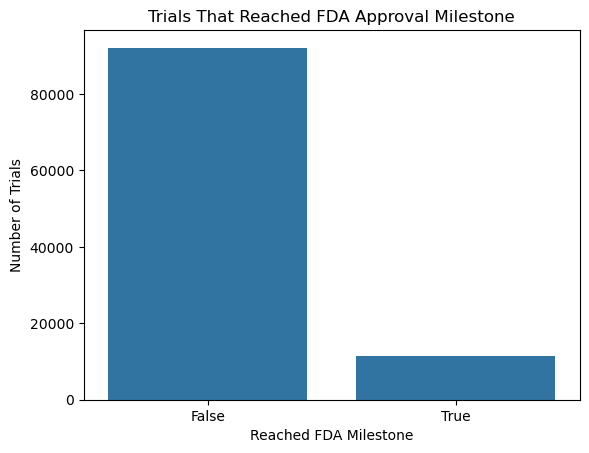

In [143]:
# clean text function
def clean_text(s):
    if pd.isna(s):
        return ''
    return unicodedata.normalize('NFKD', str(s)).encode('ascii', 'ignore').decode('utf-8').strip().lower()

# Clean brand and name columns
df['clean_brand'] = df['brand_name'].apply(clean_text)
df['clean_generic'] = df['generic_name'].apply(clean_text)
df_int['clean_name'] = df_int['name'].apply(clean_text)

# Match on clean_generic
matched_generic = df_int.merge(df, left_on='clean_name', right_on='clean_generic', how='inner')
# Match on clean_brand
matched_brand = df_int.merge(df, left_on='clean_name', right_on='clean_brand', how='inner')
# Combine matched results
matched = pd.concat([matched_generic, matched_brand], ignore_index=True)

# Build matched_df with approval info
matched_df = matched[['nct_id', 'name', 'marketing_start_date', 'manufacturer_name']].drop_duplicates()
matched_df['Is_FDA_approved'] = True

# Identify unmatched trials
all_ncts = df_int[['nct_id', 'name']].drop_duplicates()
matched_keys = matched_df[['nct_id', 'name']]
unmatched_df = pd.merge(all_ncts, matched_keys, on=['nct_id', 'name'], how='outer', indicator=True)
unmatched_df = unmatched_df[unmatched_df['_merge'] == 'left_only'].drop(columns=['_merge'])
unmatched_df['marketing_start_date'] = None
unmatched_df['manufacturer_name'] = None
unmatched_df['Is_FDA_approved'] = False

# Combine matched and unmatched and add clean_name for merging
final_df = pd.concat([matched_df, unmatched_df], ignore_index=True)
final_df['clean_name'] = final_df['name'].apply(clean_text)

# Merge with original trial data
merged = df_int.merge(final_df, on=['nct_id', 'clean_name'], how='left', suffixes=('_trial', '_approval'))

# Extract year from marketing date
merged['start_marketing_year'] = pd.to_datetime(merged['marketing_start_date'], errors='coerce').dt.year

# Determine if the trial reached FDA milestone (approved within 2 years of completion)
merged['reached_fda_milestone'] = (
    merged['start_marketing_year'].notnull() &
    (merged['start_marketing_year'] - merged['Completion_Year'] <= 2) &
    (merged['start_marketing_year'] - merged['Completion_Year'] >= 0)
)

# Build final result DataFrame
result_df = merged[['nct_id', 'Completion_Year', 'clean_name', 
                    'marketing_start_date', 'manufacturer_name', 
                    'start_marketing_year', 'reached_fda_milestone']]

# Visualization
sns.countplot(data=result_df, x='reached_fda_milestone')
plt.title('Trials That Reached FDA Approval Milestone')
plt.xlabel('Reached FDA Milestone')
plt.ylabel('Number of Trials')
plt.show()


In [144]:
result_df.clean_name.nunique()

7494

In [145]:
result_df.shape

(103431, 7)

In [146]:
unmatches=result_df[
(result_df['reached_fda_milestone']==False)]
unmatches.head(2)

,nct_id,Completion_Year,clean_name,marketing_start_date,manufacturer_name,start_marketing_year,reached_fda_milestone
0,NCT01353079,2012.0,short ragweed pollen allergenic extract,None,None,NaN,False
1,NCT03235479,2018.0,rimegepant,None,None,NaN,False


## groupby 'nct_id' and 'clean_name'

In [147]:
grouped_result = merged.groupby(['nct_id', 'clean_name'])['reached_fda_milestone'].any().reset_index()
merged = merged.drop(columns=['reached_fda_milestone'])  # avoid conflict
merged = merged.merge(grouped_result, on=['nct_id', 'clean_name'], how='left')
merged.shape

(103431, 13)

In [148]:
filtered = merged[
    (merged['reached_fda_milestone'] == True) |
    ((merged['reached_fda_milestone'] == False) & (merged['Completion_Year'] < 2022))
]
filtered.shape

(99632, 13)

In [149]:
merged_unique = filtered.drop_duplicates(subset=['nct_id', 'clean_name'])
print("Original merged shape:", filtered.shape)
print("Deduplicated shape:", merged_unique.shape)    

Original merged shape: (99632, 13)
Deduplicated shape: (15565, 13)


In [150]:
# Aggregate to decide trial-level success - Any
trial_success_any = merged_unique.groupby('nct_id')['reached_fda_milestone'].any().reset_index()

print('shape:', trial_success_any.shape)
print('unique ncts:', trial_success_any.nct_id.nunique())
print('count:', trial_success_any.reached_fda_milestone.value_counts())

shape: (12130, 2)
unique ncts: 12130
count: reached_fda_milestone
False    10635
True      1495
Name: count, dtype: int64


In [151]:
trial_success_any.to_csv('FDA_trial_success_any3_new.csv', index=False)